In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("data_regime/nifty_with_regime_5min.csv")   # <-- correct file
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

print(df.shape)
print("Regime column exists:", "regime" in df.columns)
print("Unique regimes:", df["regime"].unique())

(4112, 47)
Regime column exists: True
Unique regimes: [ 1 -1  0]


In [4]:
# EMA
df["ema_fast"] = df["close"].ewm(span=5, adjust=False).mean()
df["ema_slow"] = df["close"].ewm(span=15, adjust=False).mean()

# Cross signals
df["cross_up"] = (df["ema_fast"] > df["ema_slow"]) & (df["ema_fast"].shift(1) <= df["ema_slow"].shift(1))
df["cross_dn"] = (df["ema_fast"] < df["ema_slow"]) & (df["ema_fast"].shift(1) >= df["ema_slow"].shift(1))

# Entry signals with regime filter
df["long_entry"]  = df["cross_up"] & (df["regime"] == 1)
df["short_entry"] = df["cross_dn"] & (df["regime"] == -1)

# Exit signals
df["long_exit"]  = df["cross_dn"]
df["short_exit"] = df["cross_up"]

print(df[["long_entry","short_entry","long_exit","short_exit"]].sum())

long_entry      41
short_entry     20
long_exit      144
short_exit     144
dtype: int64


In [5]:
# STEP 3: Build position column (1 = long, -1 = short, 0 = flat)

df["position"] = 0
pos = 0

for i in range(1, len(df)):
    # LONG entry
    if df.loc[i, "long_entry"] and pos == 0:
        pos = 1

    # LONG exit
    elif df.loc[i, "long_exit"] and pos == 1:
        pos = 0

    # SHORT entry
    elif df.loc[i, "short_entry"] and pos == 0:
        pos = -1

    # SHORT exit
    elif df.loc[i, "short_exit"] and pos == -1:
        pos = 0

    df.loc[i, "position"] = pos

print(df["position"].value_counts())

position
 0    3172
 1     646
-1     294
Name: count, dtype: int64


In [6]:
# STEP 4: Enter at NEXT candle open (avoid lookahead bias)

df["position_next"] = df["position"].shift(1).fillna(0)

# Spot returns (close-to-close)
df["spot_return"] = df["close"].pct_change().fillna(0)

# Strategy return = position_next * spot_return
df["strategy_return"] = df["position_next"] * df["spot_return"]

# Equity curve
df["equity"] = (1 + df["strategy_return"]).cumprod()

print(df[["timestamp", "close", "position", "position_next", "spot_return", "strategy_return", "equity"]].head(10))

                  timestamp     close  position  position_next  spot_return  \
0 2025-10-29 09:20:00+05:30  25988.55         0            0.0     0.000000   
1 2025-10-29 09:25:00+05:30  26010.00         1            0.0     0.000825   
2 2025-10-29 09:30:00+05:30  25996.35         1            1.0    -0.000525   
3 2025-10-29 09:35:00+05:30  25965.20         0            1.0    -0.001198   
4 2025-10-29 09:40:00+05:30  25972.30         0            0.0     0.000273   
5 2025-10-29 09:45:00+05:30  25968.15         0            0.0    -0.000160   
6 2025-10-29 09:50:00+05:30  25988.20         0            0.0     0.000772   
7 2025-10-29 09:55:00+05:30  25983.70         0            0.0    -0.000173   
8 2025-10-29 10:00:00+05:30  25995.55         1            0.0     0.000456   
9 2025-10-29 10:05:00+05:30  25998.65         1            1.0     0.000119   

   strategy_return    equity  
0         0.000000  1.000000  
1         0.000000  1.000000  
2        -0.000525  0.999475  
3     

In [7]:
# STEP 5: Split Train/Test (70/30)

split = int(len(df) * 0.70)

train_df = df.iloc[:split].copy()
test_df  = df.iloc[split:].copy()

print("Train rows:", train_df.shape)
print("Test rows :", test_df.shape)

# Separate equity curves for train/test
train_df["equity_train"] = (1 + train_df["strategy_return"]).cumprod()
test_df["equity_test"]   = (1 + test_df["strategy_return"]).cumprod()

print("Train final equity:", train_df["equity_train"].iloc[-1])
print("Test final equity :", test_df["equity_test"].iloc[-1])

Train rows: (2878, 60)
Test rows : (1234, 60)
Train final equity: 1.007554471360532
Test final equity : 1.0


In [8]:
import numpy as np
import pandas as pd

def compute_metrics(df_part, name="DATA"):
    df_part = df_part.copy()

    # Equity curve
    df_part["equity"] = (1 + df_part["strategy_return"]).cumprod()

    total_return = (df_part["equity"].iloc[-1] - 1) * 100

    # Drawdown
    peak = df_part["equity"].cummax()
    dd = (df_part["equity"] / peak) - 1
    max_dd = dd.min() * 100

    # Sharpe / Sortino (5-min bars)
    ret = df_part["strategy_return"].dropna()
    mean_ret = ret.mean()
    std_ret = ret.std()

    sharpe = (mean_ret / std_ret) * np.sqrt(252*75) if std_ret != 0 else 0

    downside = ret[ret < 0]
    downside_std = downside.std()
    sortino = (mean_ret / downside_std) * np.sqrt(252*75) if downside_std != 0 else 0

    # Calmar = Return / MaxDD
    calmar = (total_return / abs(max_dd)) if max_dd != 0 else 0

    # Trades + Win rate + Profit factor + Avg duration
    trades = []
    pos = 0
    entry_idx = None
    entry_price = None

    for i in range(len(df_part)):
        p = df_part["position"].iloc[i]
        price = df_part["close"].iloc[i]

        if pos == 0 and p != 0:
            pos = p
            entry_idx = i
            entry_price = price

        elif pos != 0 and p == 0:
            exit_price = price
            pnl = (exit_price - entry_price) * pos
            duration = i - entry_idx
            trades.append((pnl, duration))
            pos = 0

    total_trades = len(trades)

    if total_trades > 0:
        pnl_list = [t[0] for t in trades]
        wins = [p for p in pnl_list if p > 0]
        losses = [p for p in pnl_list if p <= 0]

        win_rate = (len(wins) / total_trades) * 100
        profit_factor = (sum(wins) / abs(sum(losses))) if sum(losses) != 0 else np.inf
        avg_duration = np.mean([t[1] for t in trades])
    else:
        win_rate = 0
        profit_factor = 0
        avg_duration = 0

    return {
        "Dataset": name,
        "Total Return %": round(total_return, 2),
        "Sharpe": round(sharpe, 3),
        "Sortino": round(sortino, 3),
        "Calmar": round(calmar, 3),
        "Max Drawdown %": round(max_dd, 2),
        "Total Trades": total_trades,
        "Win Rate %": round(win_rate, 2),
        "Profit Factor": round(profit_factor, 3),
        "Avg Trade Duration (bars)": round(avg_duration, 2)
    }

train_metrics = compute_metrics(train_df, "TRAIN (70%)")
test_metrics  = compute_metrics(test_df, "TEST (30%)")

results = pd.DataFrame([train_metrics, test_metrics])
results

,Dataset,Total Return %,Sharpe,Sortino,Calmar,Max Drawdown %,Total Trades,Win Rate %,Profit Factor,Avg Trade Duration (bars)
0,TRAIN (70%),0.76,1.183,0.906,0.604,-1.25,59,30.51,1.181,15.93
1,TEST (30%),0.00,0.000,NaN,0.000,0.00,0,0.00,0.000,0.00


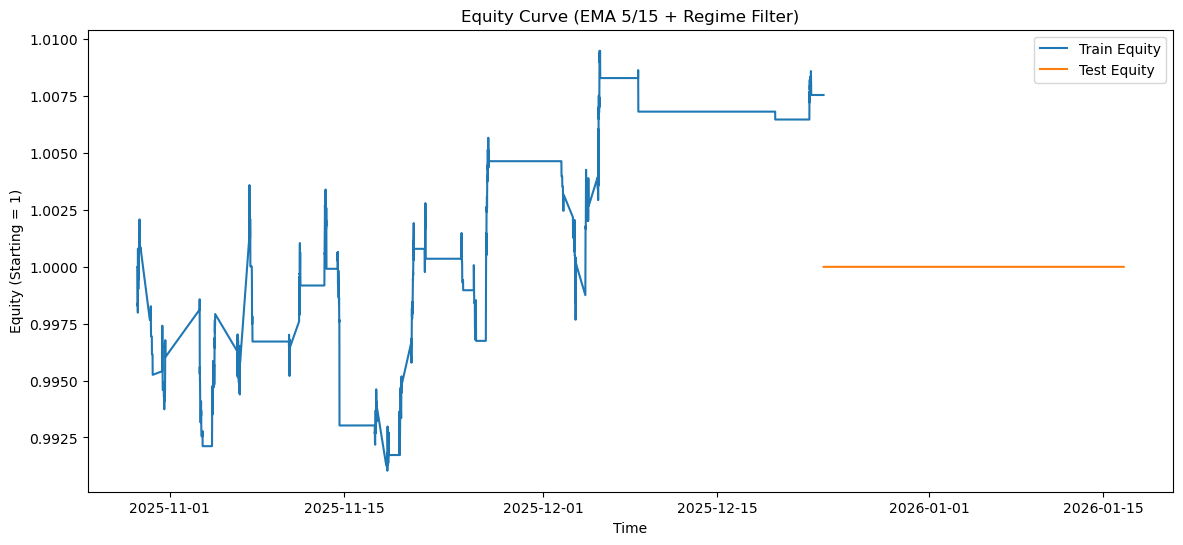

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(train_df["timestamp"], train_df["equity_train"], label="Train Equity")
plt.plot(test_df["timestamp"], test_df["equity_test"], label="Test Equity")
plt.title("Equity Curve (EMA 5/15 + Regime Filter)")
plt.xlabel("Time")
plt.ylabel("Equity (Starting = 1)")
plt.legend()
plt.show()

In [10]:
print("Test long entries:", test_df["long_entry"].sum())
print("Test short entries:", test_df["short_entry"].sum())
print("Test regimes:", test_df["regime"].value_counts())

Test long entries: 0
Test short entries: 0
Test regimes: regime
0    1234
Name: count, dtype: int64


In [13]:
df = pd.read_csv("data_regime/nifty_with_regime_fixed_5min.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

# use fixed regime as main regime
df["regime"] = df["regime_fixed"]
print(df["regime"].value_counts())

regime
 0    2096
-1    1011
 1    1005
Name: count, dtype: int64


long_entry      95
short_entry    100
long_exit      144
short_exit     144
dtype: int64
position
 0    2308
-1     935
 1     869
Name: count, dtype: int64
Train rows: (2878, 62) Test rows: (1234, 62)


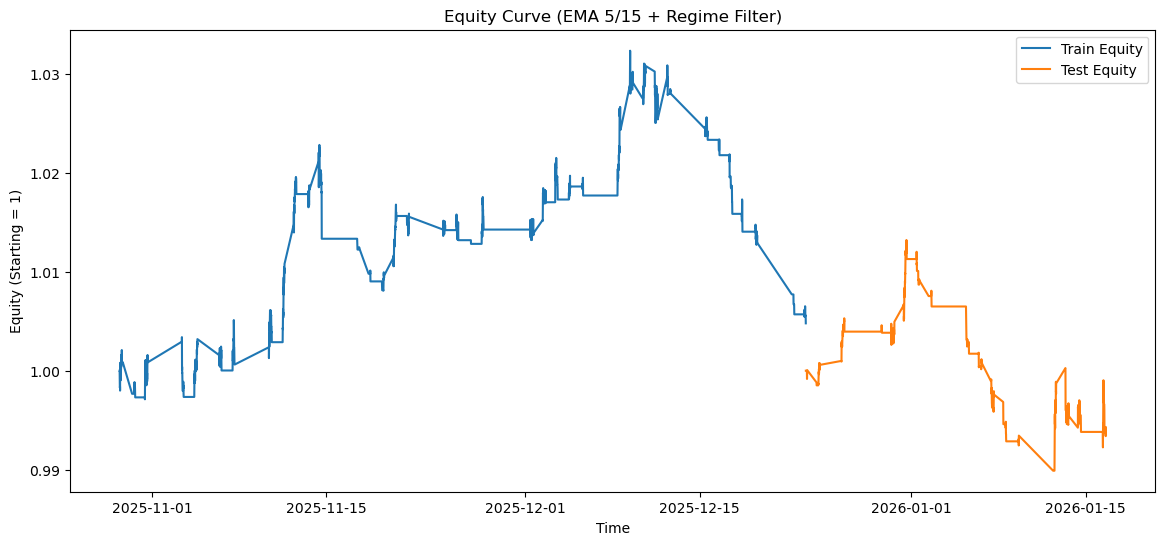

In [14]:
# =========================
# STEP 2: EMA + Signals
# =========================
df["ema_fast"] = df["close"].ewm(span=5, adjust=False).mean()
df["ema_slow"] = df["close"].ewm(span=15, adjust=False).mean()

df["cross_up"] = (df["ema_fast"] > df["ema_slow"]) & (df["ema_fast"].shift(1) <= df["ema_slow"].shift(1))
df["cross_dn"] = (df["ema_fast"] < df["ema_slow"]) & (df["ema_fast"].shift(1) >= df["ema_slow"].shift(1))

df["long_entry"]  = df["cross_up"] & (df["regime"] == 1)
df["short_entry"] = df["cross_dn"] & (df["regime"] == -1)

df["long_exit"]  = df["cross_dn"]
df["short_exit"] = df["cross_up"]

print(df[["long_entry","short_entry","long_exit","short_exit"]].sum())


# =========================
# STEP 3: Convert signals -> Position (hold until exit)
# =========================
df["position"] = 0
pos = 0

for i in range(1, len(df)):
    if pos == 0:
        if df.loc[i, "long_entry"]:
            pos = 1
        elif df.loc[i, "short_entry"]:
            pos = -1

    elif pos == 1:
        if df.loc[i, "long_exit"]:
            pos = 0

    elif pos == -1:
        if df.loc[i, "short_exit"]:
            pos = 0

    df.loc[i, "position"] = pos

print(df["position"].value_counts())


# =========================
# STEP 4: Strategy returns (enter at next candle open)
# =========================
df["spot_return"] = df["close"].pct_change().fillna(0)

# next candle execution
df["position_next"] = df["position"].shift(1).fillna(0)

df["strategy_return"] = df["position_next"] * df["spot_return"]
df["equity"] = (1 + df["strategy_return"]).cumprod()

df[["timestamp","close","position","position_next","spot_return","strategy_return","equity"]].head(10)


# =========================
# STEP 5: Split Train/Test 70/30
# =========================
split = int(len(df) * 0.70)
train_df = df.iloc[:split].copy()
test_df  = df.iloc[split:].copy()

train_df["equity_train"] = (1 + train_df["strategy_return"]).cumprod()
test_df["equity_test"]   = (1 + test_df["strategy_return"]).cumprod()

print("Train rows:", train_df.shape, "Test rows:", test_df.shape)


# =========================
# STEP 6: Metrics Function
# =========================
import numpy as np

def compute_metrics(data, name="DATA"):
    rets = data["strategy_return"].dropna()

    total_return = (1 + rets).prod() - 1

    mean_ret = rets.mean()
    std_ret  = rets.std()

    sharpe = (mean_ret / std_ret) * np.sqrt(252*78) if std_ret != 0 else 0

    downside = rets[rets < 0].std()
    sortino = (mean_ret / downside) * np.sqrt(252*78) if downside != 0 else np.nan

    equity = (1 + rets).cumprod()
    peak = equity.cummax()
    dd = (equity - peak) / peak
    max_dd = dd.min()

    calmar = (total_return / abs(max_dd)) if max_dd != 0 else np.nan

    # trades count approx: position changes from 0 -> nonzero
    pos = data["position"]
    trades = ((pos != 0) & (pos.shift(1) == 0)).sum()

    # win rate + profit factor approx using per-bar returns (simple)
    wins = rets[rets > 0].sum()
    losses = abs(rets[rets < 0].sum())
    profit_factor = (wins / losses) if losses != 0 else np.nan

    win_rate = (rets[rets > 0].count() / rets.count()) * 100 if rets.count() > 0 else 0

    return {
        "Dataset": name,
        "Total Return %": round(total_return*100, 2),
        "Sharpe": round(sharpe, 3),
        "Sortino": round(sortino, 3) if not np.isnan(sortino) else np.nan,
        "Calmar": round(calmar, 3) if not np.isnan(calmar) else np.nan,
        "Max Drawdown %": round(max_dd*100, 2),
        "Total Trades": int(trades),
        "Win Rate %": round(win_rate, 2),
        "Profit Factor": round(profit_factor, 3) if not np.isnan(profit_factor) else np.nan,
    }


# =========================
# STEP 7: Run Metrics
# =========================
train_metrics = compute_metrics(train_df, "TRAIN (70%)")
test_metrics  = compute_metrics(test_df,  "TEST (30%)")

results = pd.DataFrame([train_metrics, test_metrics])
results


# =========================
# STEP 8: Equity Curve Plot
# =========================
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(train_df["timestamp"], train_df["equity_train"], label="Train Equity")
plt.plot(test_df["timestamp"], test_df["equity_test"], label="Test Equity")
plt.title("Equity Curve (EMA 5/15 + Regime Filter)")
plt.xlabel("Time")
plt.ylabel("Equity (Starting = 1)")
plt.legend()
plt.show()

In [15]:
df.to_csv("data_regime/nifty_with_regime_fixed_5min.csv", index=False)

In [16]:
check = pd.read_csv("data_regime/nifty_with_regime_fixed_5min.csv")
print("Regime column exists:", "regime" in check.columns)
print(check["regime"].value_counts())

Regime column exists: True
regime
 0    2096
-1    1011
 1    1005
Name: count, dtype: int64


In [17]:
import pandas as pd
import numpy as np

# df already loaded from: data_regime/nifty_with_regime_fixed_5min.csv
# and EMA + signals already created

# 1) Build positions (hold until exit)
pos = 0
positions = []

for i in range(len(df)):
    if df.loc[i, "long_entry"]:
        pos = 1
    elif df.loc[i, "short_entry"]:
        pos = -1
    elif pos == 1 and df.loc[i, "long_exit"]:
        pos = 0
    elif pos == -1 and df.loc[i, "short_exit"]:
        pos = 0
    positions.append(pos)

df["position"] = positions

# 2) Next candle return
df["spot_return"] = df["close"].pct_change().fillna(0)

# 3) Strategy return (enter at next candle open => shift position by 1)
df["position_next"] = df["position"].shift(1).fillna(0)
df["strategy_return"] = df["position_next"] * df["spot_return"]

# 4) Trade outcome label (profit/loss per bar based)
df["target"] = (df["strategy_return"] > 0).astype(int)

print(df["target"].value_counts())
df[["timestamp","position","strategy_return","target"]].head()

target
0    2586
1    1526
Name: count, dtype: int64


,timestamp,position,strategy_return,target
0,2025-10-29 09:20:00+05:30,0,0.000000,0
1,2025-10-29 09:25:00+05:30,1,0.000000,0
2,2025-10-29 09:30:00+05:30,1,-0.000525,0
3,2025-10-29 09:35:00+05:30,-1,-0.001198,0
4,2025-10-29 09:40:00+05:30,-1,-0.000273,0


In [18]:
import numpy as np

# ---- Time based features ----
df["hour"] = df["timestamp"].dt.hour
df["minute"] = df["timestamp"].dt.minute
df["dayofweek"] = df["timestamp"].dt.dayofweek

# ---- Signal strength ----
df["ema_diff"] = df["ema_fast"] - df["ema_slow"]
df["ema_diff_pct"] = df["ema_diff"] / df["close"]

# ---- Lag features (example: last 1,2,3 candles) ----
lag_cols = ["spot_return", "futures_basis", "avg_iv", "iv_spread", "pcr_oi", "ema_diff_pct"]

for col in lag_cols:
    for l in [1, 2, 3]:
        df[f"{col}_lag{l}"] = df[col].shift(l)

# ---- Final ML dataset ----
feature_cols = [
    "regime", "hour", "minute", "dayofweek",
    "ema_fast", "ema_slow", "ema_diff_pct",
    "avg_iv", "iv_spread", "pcr_oi",
    "delta_call", "gamma_call", "vega_call",
    "futures_basis", "spot_return",
] + [f"{c}_lag{l}" for c in lag_cols for l in [1,2,3]]

df_ml = df.dropna(subset=feature_cols + ["target"]).copy()

print("ML dataset shape:", df_ml.shape)
print("Target balance:\n", df_ml["target"].value_counts(normalize=True))

ML dataset shape: (4109, 85)
Target balance:
 target
0    0.62862
1    0.37138
Name: proportion, dtype: float64


In [20]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from xgboost import XGBClassifier
import numpy as np

X = df_ml[feature_cols]
y = df_ml["target"]

tscv = TimeSeriesSplit(n_splits=5)

auc_scores = []
acc_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_xgb = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    )

    model_xgb.fit(X_train, y_train)

    preds = model_xgb.predict(X_val)
    proba = model_xgb.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, preds)
    auc = roc_auc_score(y_val, proba)

    acc_scores.append(acc)
    auc_scores.append(auc)

    print(f"\nFold {fold} Accuracy: {acc:.4f} | AUC: {auc:.4f}")

print("\nAverage Accuracy:", np.mean(acc_scores))
print("Average AUC:", np.mean(auc_scores))


Fold 1 Accuracy: 0.8099 | AUC: 0.8731

Fold 2 Accuracy: 0.6827 | AUC: 0.7992

Fold 3 Accuracy: 0.9123 | AUC: 0.9372

Fold 4 Accuracy: 0.7032 | AUC: 0.8334

Fold 5 Accuracy: 0.8070 | AUC: 0.9326

Average Accuracy: 0.7830409356725145
Average AUC: 0.8750946574268472


In [21]:
from xgboost import XGBClassifier
import numpy as np

X = df_ml[feature_cols]
y = df_ml["target"]

split = int(len(df_ml) * 0.70)

X_train = X.iloc[:split]
y_train = y.iloc[:split]

X_test = X.iloc[split:]
y_test = y.iloc[split:]

final_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

final_xgb.fit(X_train, y_train)

# Predict probability on full dataset (for ML filter)
df_ml["xgb_proba"] = final_xgb.predict_proba(X)[:, 1]
df_ml["xgb_pred"]  = (df_ml["xgb_proba"] > 0.5).astype(int)

print("Train proba range:", df_ml["xgb_proba"].min(), "to", df_ml["xgb_proba"].max())
print(df_ml[["xgb_proba","xgb_pred","target"]].head())

Train proba range: 0.00047921889927238226 to 0.9944842457771301
   xgb_proba  xgb_pred  target
3   0.042088         0       0
4   0.090097         0       0
5   0.879525         1       1
6   0.014896         0       0
7   0.886230         1       1


In [22]:
# ML Filter: take trade only if model predicts profitable (xgb_pred == 1)
df_ml["position_ml"] = df_ml["position"] * df_ml["xgb_pred"]

# Next candle execution
df_ml["position_ml_next"] = df_ml["position_ml"].shift(1).fillna(0)

# Returns
df_ml["spot_return"] = df_ml["close"].pct_change().fillna(0)

# Strategy returns
df_ml["strategy_return_baseline"] = df_ml["position_next"] * df_ml["spot_return"]
df_ml["strategy_return_xgb"]      = df_ml["position_ml_next"] * df_ml["spot_return"]

# Equity curves
df_ml["equity_baseline"] = (1 + df_ml["strategy_return_baseline"]).cumprod()
df_ml["equity_xgb"]      = (1 + df_ml["strategy_return_xgb"]).cumprod()

print("Baseline final equity:", df_ml["equity_baseline"].iloc[-1])
print("XGB final equity:", df_ml["equity_xgb"].iloc[-1])
print("Total baseline trades:", (df_ml["position"] != 0).sum())
print("Total XGB trades:", (df_ml["position_ml"] != 0).sum())

Baseline final equity: 0.992203448515009
XGB final equity: 0.9593658281120062
Total baseline trades: 3071
Total XGB trades: 1387


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Metrics function ----
def metrics_from_returns(ret_series, name=""):
    ret_series = ret_series.fillna(0)

    equity = (1 + ret_series).cumprod()
    total_return = (equity.iloc[-1] - 1) * 100

    # drawdown
    peak = equity.cummax()
    dd = (equity / peak) - 1
    max_dd = dd.min() * 100

    # sharpe / sortino (5-min bars)
    mean_r = ret_series.mean()
    std_r = ret_series.std()
    sharpe = (mean_r / std_r) * np.sqrt(252*75) if std_r != 0 else 0

    neg_std = ret_series[ret_series < 0].std()
    sortino = (mean_r / neg_std) * np.sqrt(252*75) if neg_std != 0 else 0

    # calmar
    calmar = (total_return/100) / abs(max_dd/100) if max_dd != 0 else 0

    return {
        "Strategy": name,
        "Total Return %": round(total_return, 2),
        "Sharpe": round(sharpe, 3),
        "Sortino": round(sortino, 3),
        "Calmar": round(calmar, 3),
        "Max Drawdown %": round(max_dd, 2)
    }

# ---- Compare Baseline vs XGB ----
baseline_m = metrics_from_returns(df_ml["strategy_return_baseline"], "Baseline")
xgb_m      = metrics_from_returns(df_ml["strategy_return_xgb"], "XGBoost Filter")

results_compare = pd.DataFrame([baseline_m, xgb_m])
results_compare

,Strategy,Total Return %,Sharpe,Sortino,Calmar,Max Drawdown %
0,Baseline,-0.78,-0.484,-0.559,-0.174,-4.49
1,XGBoost Filter,-4.06,-4.334,-3.302,-0.941,-4.32


In [24]:
from sklearn.preprocessing import StandardScaler
import numpy as np

SEQ_LEN = 10

# features for LSTM (use same feature_cols you used in XGB)
X_all = df_ml[feature_cols].values
y_all = df_ml["target"].values

# scale
scaler_lstm = StandardScaler()
X_scaled = scaler_lstm.fit_transform(X_all)

# make sequences
X_seq, y_seq = [], []
for i in range(SEQ_LEN, len(X_scaled)):
    X_seq.append(X_scaled[i-SEQ_LEN:i])
    y_seq.append(y_all[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("X_seq shape:", X_seq.shape)   # (samples, 10, features)
print("y_seq shape:", y_seq.shape)
print("Target counts:", np.bincount(y_seq))

X_seq shape: (4099, 10, 33)
y_seq shape: (4099,)
Target counts: [2577 1522]


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 70/30 split (time-based)
split = int(len(X_seq) * 0.70)

X_train_seq = X_seq[:split]
y_train_seq = y_seq[:split]

X_test_seq  = X_seq[split:]
y_test_seq  = y_seq[split:]

print("Train:", X_train_seq.shape, y_train_seq.shape)
print("Test :", X_test_seq.shape, y_test_seq.shape)

# LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

print("Training done")

Train: (2869, 10, 33) (2869,)
Test : (1230, 10, 33) (1230,)


c:\Users\spart\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6035 - loss: 0.6686 - val_accuracy: 0.5488 - val_loss: 0.6671
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6227 - loss: 0.6504 - val_accuracy: 0.5784 - val_loss: 0.6538
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6392 - loss: 0.6454 - val_accuracy: 0.5645 - val_loss: 0.6554
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6370 - loss: 0.6381 - val_accuracy: 0.5662 - val_loss: 0.6548
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6388 - loss: 0.6309 - val_accuracy: 0.5557 - val_loss: 0.6574
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6375 - loss: 0.6202 - val_accuracy: 0.5610 - val_loss: 0.6568
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6514 - loss: 0.6137 - val_accuracy: 0.5488 - val_loss: 0.6663
Training done


In [27]:
seq_len = 10   # must be same as used in LSTM sequence creation

lstm_proba = model.predict(X_seq, verbose=0).flatten()

# align with df_ml rows (because sequences start after seq_len rows)
df_ml = df_ml.iloc[seq_len:].copy().reset_index(drop=True)

df_ml["lstm_proba"] = lstm_proba
df_ml["lstm_pred"]  = (df_ml["lstm_proba"] > 0.5).astype(int)

print(df_ml[["lstm_proba", "lstm_pred", "target"]].head())
print("LSTM proba range:", df_ml["lstm_proba"].min(), "to", df_ml["lstm_proba"].max())

   lstm_proba  lstm_pred  target
0    0.318605          0       1
1    0.319921          0       1
2    0.316898          0       0
3    0.292146          0       1
4    0.320976          0       0
LSTM proba range: 0.21226821839809418 to 0.6499770879745483


In [28]:
# =========================
# STEP: ML Filtered Backtest
# =========================

# Baseline position (already exists)
df_ml["position_base"] = df_ml["position"]

# XGBoost filter (take trade only if xgb_proba > 0.5)
df_ml["position_xgb"] = np.where(df_ml["xgb_pred"] == 1, df_ml["position_base"], 0)

# LSTM filter (take trade only if lstm_proba > 0.5)
df_ml["position_lstm"] = np.where(df_ml["lstm_pred"] == 1, df_ml["position_base"], 0)

# Returns
df_ml["spot_return"] = df_ml["close"].pct_change().fillna(0)

df_ml["ret_base"] = df_ml["position_base"].shift(1).fillna(0) * df_ml["spot_return"]
df_ml["ret_xgb"]  = df_ml["position_xgb"].shift(1).fillna(0)  * df_ml["spot_return"]
df_ml["ret_lstm"] = df_ml["position_lstm"].shift(1).fillna(0) * df_ml["spot_return"]

# Equity curves
df_ml["eq_base"] = (1 + df_ml["ret_base"]).cumprod()
df_ml["eq_xgb"]  = (1 + df_ml["ret_xgb"]).cumprod()
df_ml["eq_lstm"] = (1 + df_ml["ret_lstm"]).cumprod()

print("Final Equity:")
print("Baseline:", df_ml["eq_base"].iloc[-1])
print("XGBoost :", df_ml["eq_xgb"].iloc[-1])
print("LSTM    :", df_ml["eq_lstm"].iloc[-1])

Final Equity:
Baseline: 0.9915732767087287
XGBoost : 0.9594552923931907
LSTM    : 1.01693628708389


In [29]:
def summary(eq_col, ret_col, name):
    total_return = (df_ml[eq_col].iloc[-1] - 1) * 100
    sharpe = (df_ml[ret_col].mean() / df_ml[ret_col].std()) * np.sqrt(252*78) if df_ml[ret_col].std() != 0 else 0
    max_dd = ((df_ml[eq_col] / df_ml[eq_col].cummax()) - 1).min() * 100
    return {
        "Model": name,
        "Total Return %": round(total_return, 2),
        "Sharpe": round(sharpe, 3),
        "Max Drawdown %": round(max_dd, 2)
    }

compare = pd.DataFrame([
    summary("eq_base", "ret_base", "Baseline"),
    summary("eq_xgb", "ret_xgb", "XGBoost Filter"),
    summary("eq_lstm", "ret_lstm", "LSTM Filter")
])

compare

,Model,Total Return %,Sharpe,Max Drawdown %
0,Baseline,-0.84,-0.538,-4.49
1,XGBoost Filter,-4.05,-4.427,-4.32
2,LSTM Filter,1.69,2.141,-1.59


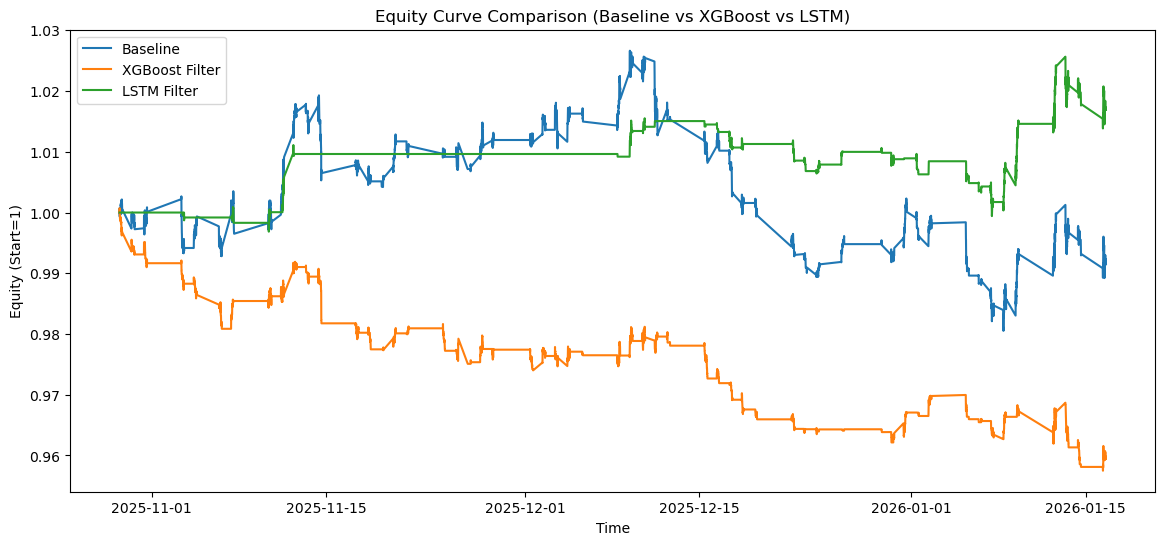

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_ml["timestamp"], df_ml["eq_base"], label="Baseline")
plt.plot(df_ml["timestamp"], df_ml["eq_xgb"], label="XGBoost Filter")
plt.plot(df_ml["timestamp"], df_ml["eq_lstm"], label="LSTM Filter")

plt.title("Equity Curve Comparison (Baseline vs XGBoost vs LSTM)")
plt.xlabel("Time")
plt.ylabel("Equity (Start=1)")
plt.legend()
plt.show()

In [31]:
import os
import joblib
import matplotlib.pyplot as plt

os.makedirs("results_ml", exist_ok=True)

# 1) Save final dataframe with predictions
df_ml.to_csv("results_ml/ml_predictions_full.csv", index=False)
print("Saved: results_ml/ml_predictions_full.csv")

# 2) Save equity curves dataframe
equity_df = pd.DataFrame({
    "timestamp": df_ml["timestamp"],
    "equity_baseline": equity_baseline,
    "equity_xgb": equity_xgb,
    "equity_lstm": equity_lstm
})
equity_df.to_csv("results_ml/equity_curves_comparison.csv", index=False)
print("Saved: results_ml/equity_curves_comparison.csv")

# 3) Save plot
plt.figure(figsize=(14,6))
plt.plot(df_ml["timestamp"], equity_baseline, label="Baseline")
plt.plot(df_ml["timestamp"], equity_xgb, label="XGBoost Filter")
plt.plot(df_ml["timestamp"], equity_lstm, label="LSTM Filter")
plt.title("Equity Curve Comparison (Baseline vs XGBoost vs LSTM)")
plt.xlabel("Time")
plt.ylabel("Equity (Start=1)")
plt.legend()
plt.tight_layout()
plt.savefig("results_ml/equity_curve_comparison.png", dpi=200)
plt.show()

print("Saved: results_ml/equity_curve_comparison.png")

# 4) Save XGBoost model
joblib.dump(final_xgb, "results_ml/xgb_model.pkl")
print("Saved: results_ml/xgb_model.pkl")

# 5) Save LSTM model
model.save("results_ml/lstm_model.h5")
print("Saved: results_ml/lstm_model.h5")

Saved: results_ml/ml_predictions_full.csv


NameError: name 'equity_baseline' is not defined

In [32]:
equity_baseline = df_ml["equity_baseline"].values
equity_xgb      = df_ml["equity_xgb"].values
equity_lstm     = df_ml["equity_lstm"].values

KeyError: 'equity_lstm'

In [33]:
[c for c in df_ml.columns if "equity" in c.lower()]

['equity', 'equity_baseline', 'equity_xgb']

In [34]:
equity_baseline = df_ml["equity_baseline"].values
equity_xgb      = df_ml["equity_xgb"].values
equity_lstm     = df_ml["equity_lstm_filter"].values

KeyError: 'equity_lstm_filter'

In [35]:
[c for c in df_ml.columns if "equity" in c.lower()]

['equity', 'equity_baseline', 'equity_xgb']

In [36]:
[c for c in df_ml.columns if "lstm" in c.lower()]

['lstm_proba', 'lstm_pred', 'position_lstm', 'ret_lstm', 'eq_lstm']

In [37]:
equity_cols = [c for c in df_ml.columns if "equity" in c.lower()]
print("Equity columns found:", equity_cols)

# pick baseline
equity_baseline_col = [c for c in equity_cols if "baseline" in c.lower()][0]

# pick xgb
equity_xgb_col = [c for c in equity_cols if "xgb" in c.lower()][0]

# pick lstm (anything with lstm)
equity_lstm_col = [c for c in equity_cols if "lstm" in c.lower()][0]

equity_baseline = df_ml[equity_baseline_col].values
equity_xgb      = df_ml[equity_xgb_col].values
equity_lstm     = df_ml[equity_lstm_col].values

print("Using columns:", equity_baseline_col, equity_xgb_col, equity_lstm_col)

Equity columns found: ['equity', 'equity_baseline', 'equity_xgb']


IndexError: list index out of range

In [38]:
# Create missing LSTM equity curve
df_ml["equity_lstm"] = (1 + df_ml["ret_lstm"]).cumprod()

print("Now equity columns:", [c for c in df_ml.columns if "equity" in c.lower()])
print("Final LSTM equity:", df_ml["equity_lstm"].iloc[-1])

Now equity columns: ['equity', 'equity_baseline', 'equity_xgb', 'equity_lstm']
Final LSTM equity: 1.01693628708389


Saved: results_ml/ml_predictions_full.csv
Saved: results_ml/equity_curves_comparison.csv


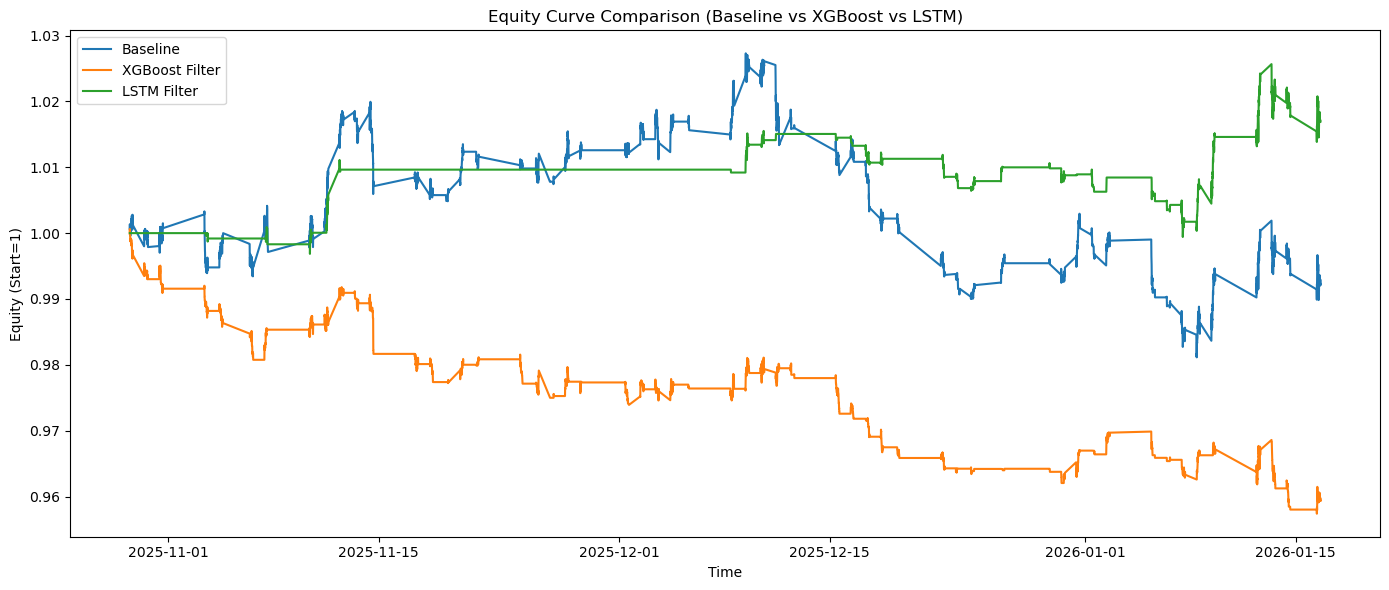

Saved: results_ml/equity_curve_comparison.png
Saved: results_ml/xgb_model.pkl
Saved: results_ml/lstm_model.h5


In [39]:
import os
import joblib
import matplotlib.pyplot as plt
import pandas as pd

os.makedirs("results_ml", exist_ok=True)

equity_baseline = df_ml["equity_baseline"].values
equity_xgb      = df_ml["equity_xgb"].values
equity_lstm     = df_ml["equity_lstm"].values

# Save full predictions
df_ml.to_csv("results_ml/ml_predictions_full.csv", index=False)
print("Saved: results_ml/ml_predictions_full.csv")

# Save equity curves
equity_df = pd.DataFrame({
    "timestamp": df_ml["timestamp"],
    "equity_baseline": equity_baseline,
    "equity_xgb": equity_xgb,
    "equity_lstm": equity_lstm
})
equity_df.to_csv("results_ml/equity_curves_comparison.csv", index=False)
print("Saved: results_ml/equity_curves_comparison.csv")

# Save plot
plt.figure(figsize=(14,6))
plt.plot(df_ml["timestamp"], equity_baseline, label="Baseline")
plt.plot(df_ml["timestamp"], equity_xgb, label="XGBoost Filter")
plt.plot(df_ml["timestamp"], equity_lstm, label="LSTM Filter")
plt.title("Equity Curve Comparison (Baseline vs XGBoost vs LSTM)")
plt.xlabel("Time")
plt.ylabel("Equity (Start=1)")
plt.legend()
plt.tight_layout()
plt.savefig("results_ml/equity_curve_comparison.png", dpi=200)
plt.show()
print("Saved: results_ml/equity_curve_comparison.png")

# Save models
joblib.dump(final_xgb, "results_ml/xgb_model.pkl")
print("Saved: results_ml/xgb_model.pkl")

model.save("results_ml/lstm_model.h5")
print("Saved: results_ml/lstm_model.h5")